In [75]:
# Imports required to run code, most imports are already in their respective file, but for testing they're left here
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyspark
import seaborn as sns
import data_functions
import plot_functions
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor, GBTRegressor, LinearRegression, RandomForestRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pyspark.sql.functions as F
import pyspark.sql.types as T

from scipy.stats import linregress

In [8]:
# Configure/Starting Spark Session
conf = pyspark.SparkConf().setAll([('spark.master', 'local[4]'),
                                   ('spark.app.name', 'Flight Analysis Project')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# Set severity to ERROR
logger = spark._jvm.org.apache.log4j
logger.LogManager.getLogger("org").setLevel(logger.Level.ERROR)
logger.LogManager.getLogger("akka").setLevel(logger.Level.ERROR)
spark.sparkContext.setLogLevel("ERROR")

In [9]:
# Load data into DataFrame
df = spark.read.format("csv").option("header", "true").load("/flight_data.csv")

In [10]:
# drop airport_codes, airline_number, flight_number, scan_date, currency = USD, departure/arrival times
dropdf = df.drop('from_airport_code', 'dest_airport_code', 'airline_number', 'flight_number', 'scan_date', 'currency', 'departure_time', 'arrival_time', 'aircraft_type')

# Display new schema
# dropdf.printSchema()

# Display the first few rows of the new DataFrame
print(dropdf.show(3, truncate=False, vertical=True))

-RECORD 0------------------------------------------------------
 from_country                    | Algeria                     
 dest_country                    | Argentina                   
 airline_name                    | [Air France| Iberia| LATAM] 
 duration                        | 1425                        
 stops                           | 3                           
 price                           | 1279.00                     
 co2_emissions                   | 1320000                     
 avg_co2_emission_for_this_route | 1320000                     
 co2_percentage                  | 0%                          
-RECORD 1------------------------------------------------------
 from_country                    | Algeria                     
 dest_country                    | Argentina                   
 airline_name                    | [Air France| Iberia| LATAM] 
 duration                        | 1425                        
 stops                           | 3    

In [13]:
# Get the count of missing values in each column
missing_counts = dropdf.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in dropdf.columns])
missing_counts.show(truncate = False)

+------------+------------+------------+--------+-----+-----+-------------+-------------------------------+--------------+
|from_country|dest_country|airline_name|duration|stops|price|co2_emissions|avg_co2_emission_for_this_route|co2_percentage|
+------------+------------+------------+--------+-----+-----+-------------+-------------------------------+--------------+
|0           |0           |0           |0       |0    |1353 |4868         |88402                          |88402         |
+------------+------------+------------+--------+-----+-----+-------------+-------------------------------+--------------+



In [14]:
# Drop all nan values and print sum. statistics
cleaned_data = dropdf.na.drop()
cleaned_data.describe().show(vertical=True)

-RECORD 0-----------------------------------------------
 summary                         | count                
 from_country                    | 905712               
 dest_country                    | 905712               
 airline_name                    | 905712               
 duration                        | 905712               
 stops                           | 905712               
 price                           | 905712               
 co2_emissions                   | 905712               
 avg_co2_emission_for_this_route | 905712               
 co2_percentage                  | 905712               
-RECORD 1-----------------------------------------------
 summary                         | mean                 
 from_country                    | null                 
 dest_country                    | null                 
 airline_name                    | null                 
 duration                        | 1424.901870572544    
 stops                         

In [15]:
# Number of entries categorized by number of stops
cleaned_data.groupBy('stops').count().show()

+-----+------+
|stops| count|
+-----+------+
|    3| 55414|
|    0| 13114|
|    5|   209|
|    1|369069|
|    4|  2359|
|    2|465535|
|    6|    12|
+-----+------+



In [16]:
# Generate data for model by using prepare_data function
training_data, testing_data = data_functions.prepare_data(cleaned_data)
training_data.cache()
testing_data.cache()

DataFrame[airline_name: string, duration: float, stops: string, price: float, airline_name_index: double, airline_name_encoded: vector, stops_int: int, features: vector]

In [17]:
# Retrieve model/predictions/r2 from functions defined in python script
lr_model, lr_predictions, lr_r2_score = data_functions.fit_and_evaluate_model(LinearRegression, training_data, testing_data)
dt_model, dt_predictions, dt_r2_score = data_functions.fit_and_evaluate_model(DecisionTreeRegressor, training_data, testing_data)
rf_model, rf_predictions, rf_r2_score = data_functions.fit_and_evaluate_model(RandomForestRegressor, training_data, testing_data)
gbt_model, gbt_predictions, gbt_r2_score = data_functions.fit_and_evaluate_model(GBTRegressor, training_data, testing_data)

data_functions.display_performance(lr_r2_score=lr_r2_score,
                    dt_r2_score=dt_r2_score,
                    rf_r2_score=rf_r2_score,
                    gbt_r2_score=gbt_r2_score)

2023-06-06 03:19:37,697 WARN netlib.InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
2023-06-06 03:19:37,700 WARN netlib.InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
2023-06-06 03:19:37,733 WARN netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
2023-06-06 03:19:37,734 WARN netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
2023-06-06 03:19:37,904 INFO optimize.LBFGS: Step Size: 1.080
2023-06-06 03:19:37,908 INFO optimize.LBFGS: Val and Grad Norm: 0.445602 (rel: 0.109) 1.01283
2023-06-06 03:19:38,054 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 03:19:38,056 INFO optimize.LBFGS: Val and Grad Norm: 0.219094 (rel: 0.508) 0.112551
2023-06-06 03:19:38,266 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 03:19:38,267 INFO optimize.LBFGS: Val and Grad Norm: 0.214686 (rel: 0.0201) 0.0433481
2023-06-06 03:19:38

,Model,R2 Score
0,Linear Regression,0.553389
1,Decision Tree Regression,0.243531
2,Random Forest Regression,0.271677
3,Gradient-Boosted Tree Regression,0.325798


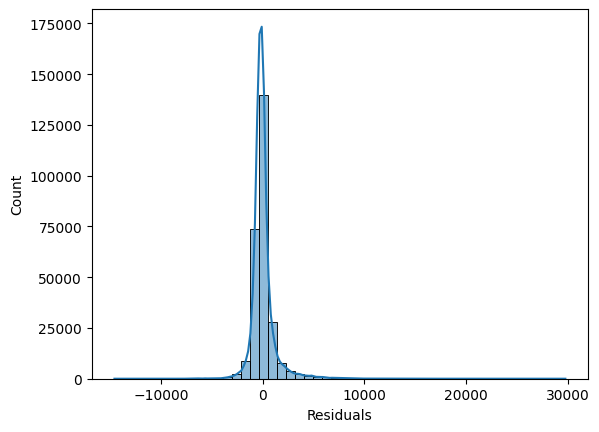

In [23]:
# LR residual plot
plot_functions.plot_residuals(lr_model.evaluate(testing_data))

2023-06-06 04:34:24,491 INFO optimize.LBFGS: Step Size: 1.059                   
2023-06-06 04:34:24,491 INFO optimize.LBFGS: Val and Grad Norm: 0.418371 (rel: 0.163) 0.988628
2023-06-06 04:34:24,584 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 04:34:24,585 INFO optimize.LBFGS: Val and Grad Norm: 0.203626 (rel: 0.513) 0.113238
2023-06-06 04:34:24,734 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 04:34:24,734 INFO optimize.LBFGS: Val and Grad Norm: 0.199177 (rel: 0.0218) 0.0419907
2023-06-06 04:34:24,801 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 04:34:24,801 INFO optimize.LBFGS: Val and Grad Norm: 0.198121 (rel: 0.00531) 0.0187339
2023-06-06 04:34:24,859 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 04:34:24,859 INFO optimize.LBFGS: Val and Grad Norm: 0.197779 (rel: 0.00173) 0.0141577
2023-06-06 04:34:24,921 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 04:34:24,921 INFO optimize.LBFGS: Val and Grad Norm: 0.197512 (rel: 0.00135) 0.00375114
2023-06-06 04:34:25,090 INF

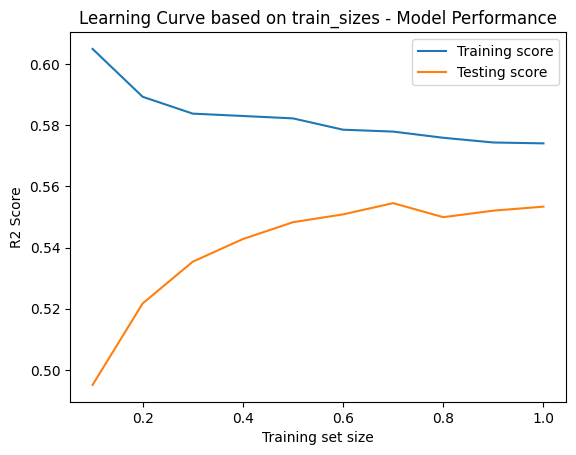

In [24]:
plot_functions.plot_learning_curve(training_data, testing_data)

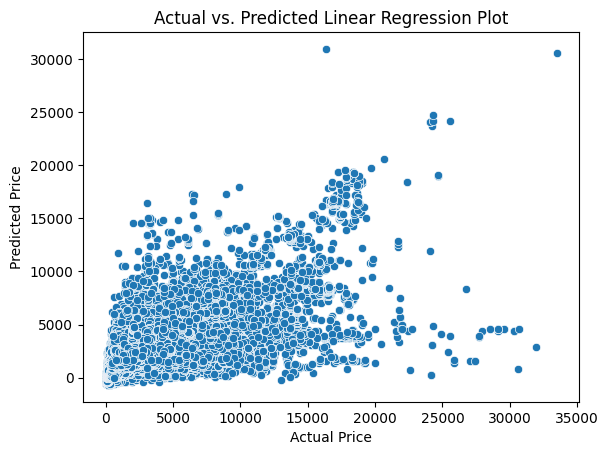

In [25]:
plot_functions.plot_actual_vs_predicted(lr_predictions)

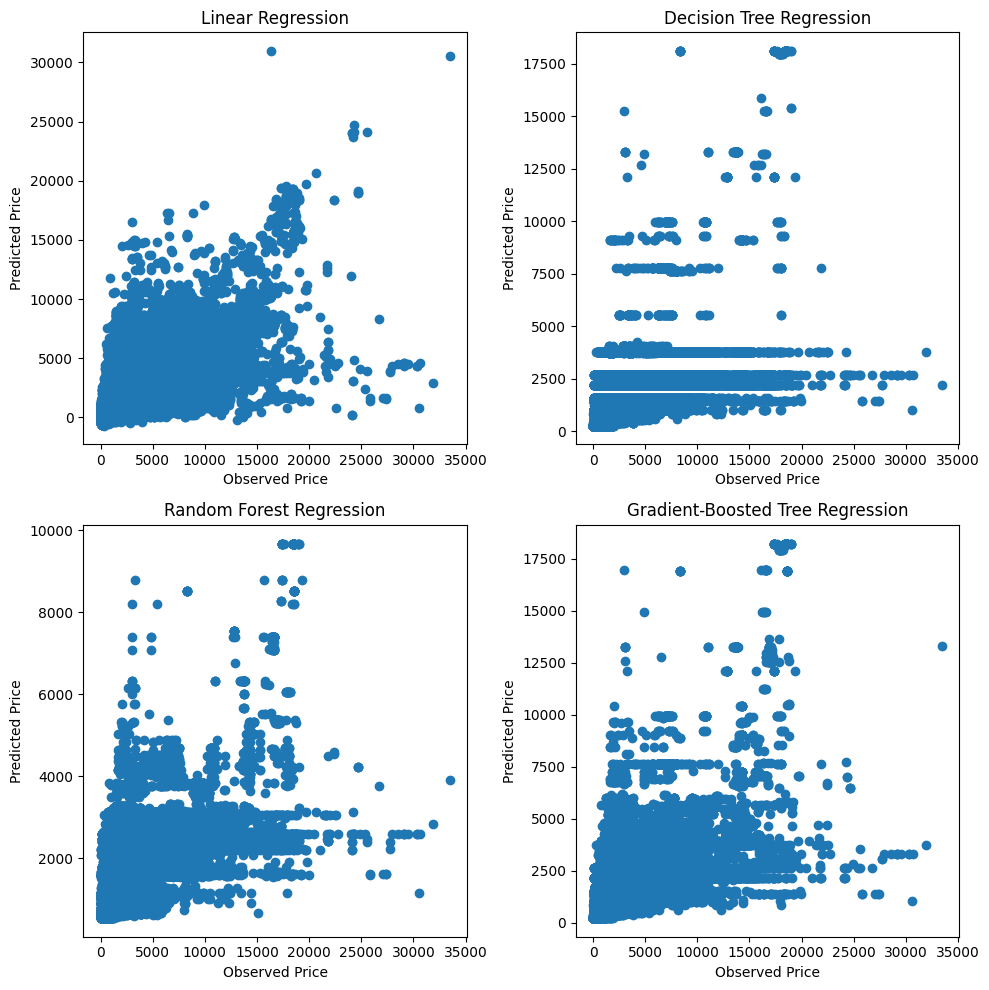

In [26]:
plot_functions.plot_scatter_plots(lr_predictions, dt_predictions, rf_predictions, gbt_predictions)

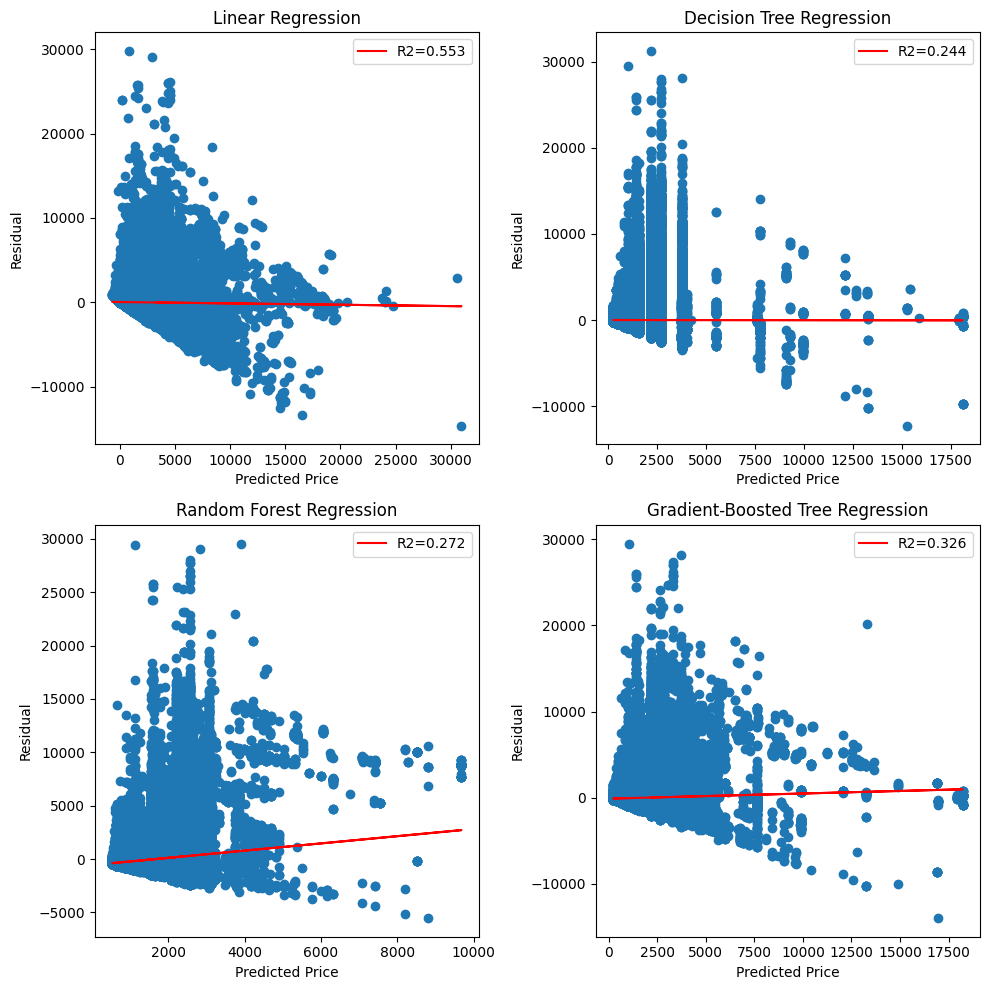

In [32]:
plot_functions.plot_residual_models(lr_predictions, dt_predictions, rf_predictions, gbt_predictions, 
                                    lr_r2_score, dt_r2_score, rf_r2_score, gbt_r2_score)

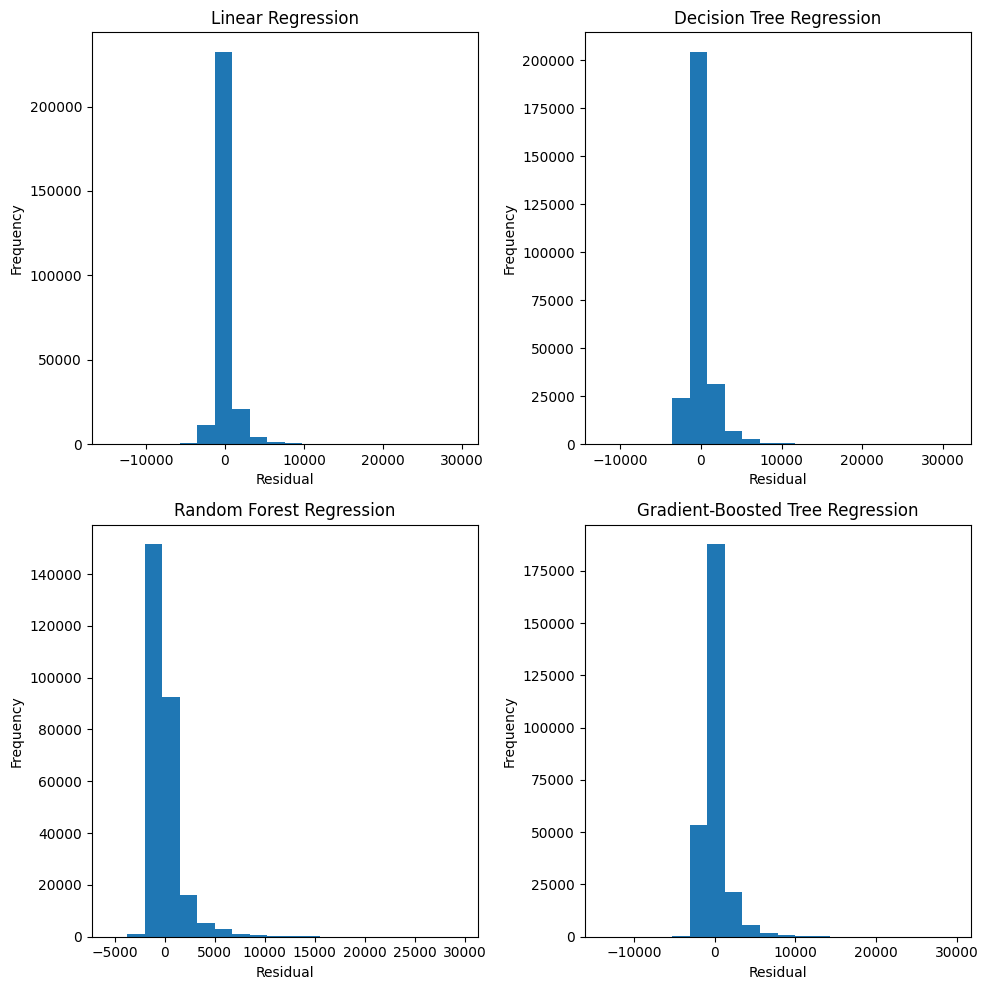

In [34]:
plot_functions.plot_residual_histograms(lr_predictions, dt_predictions, rf_predictions, gbt_predictions)

In [35]:
# Create New Dataset consisting of price values below 15000 and stops of 3 and less.
filtered_df = cleaned_data.withColumn("stops", col("stops").cast("float"))
filtered_df = filtered_df.withColumn("price", col("price").cast("float"))
filtered_df = filtered_df.filter((col("stops") <= 3) & (col("price") <= 15000))

# Create subsets with restrictions on price
df5k  = filtered_df.filter(col("price") < 5000)
df10k = filtered_df.filter((col("price") >= 5000) & (col("price") < 10000))
df15k = filtered_df.filter((col("price") >= 10000) & (col("price") <= 15000))

In [36]:
# Run prepare_data function for filtered dataframes
training_data, testing_data = data_functions.prepare_data(filtered_df)
training_data.cache()
testing_data.cache()

DataFrame[airline_name: string, duration: float, stops: float, price: float, airline_name_index: double, airline_name_encoded: vector, stops_int: int, features: vector]

In [37]:
# Retrieve model/predictions/r2 from functions
lr_model, lr_predictions, lr_r2_score = data_functions.fit_and_evaluate_model(LinearRegression, training_data, testing_data)
dt_model, dt_predictions, dt_r2_score = data_functions.fit_and_evaluate_model(DecisionTreeRegressor, training_data, testing_data)
rf_model, rf_predictions, rf_r2_score = data_functions.fit_and_evaluate_model(RandomForestRegressor, training_data, testing_data)
gbt_model, gbt_predictions, gbt_r2_score = data_functions.fit_and_evaluate_model(GBTRegressor, training_data, testing_data)

data_functions.display_performance(lr_r2_score=lr_r2_score,
                    dt_r2_score=dt_r2_score,
                    rf_r2_score=rf_r2_score,
                    gbt_r2_score=gbt_r2_score)

2023-06-06 04:47:27,041 INFO optimize.LBFGS: Step Size: 1.073                   
2023-06-06 04:47:27,041 INFO optimize.LBFGS: Val and Grad Norm: 0.452509 (rel: 0.0950) 1.02068
2023-06-06 04:47:27,138 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 04:47:27,138 INFO optimize.LBFGS: Val and Grad Norm: 0.221497 (rel: 0.511) 0.114369
2023-06-06 04:47:27,217 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 04:47:27,217 INFO optimize.LBFGS: Val and Grad Norm: 0.216916 (rel: 0.0207) 0.0450753
2023-06-06 04:47:27,307 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 04:47:27,307 INFO optimize.LBFGS: Val and Grad Norm: 0.215707 (rel: 0.00557) 0.0181450
2023-06-06 04:47:27,397 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 04:47:27,397 INFO optimize.LBFGS: Val and Grad Norm: 0.215394 (rel: 0.00145) 0.0134348
2023-06-06 04:47:27,503 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 04:47:27,503 INFO optimize.LBFGS: Val and Grad Norm: 0.215156 (rel: 0.00111) 0.00287111
2023-06-06 04:47:27,706 INF

,Model,R2 Score
0,Linear Regression,0.547066
1,Decision Tree Regression,0.246561
2,Random Forest Regression,0.263591
3,Gradient-Boosted Tree Regression,0.315343


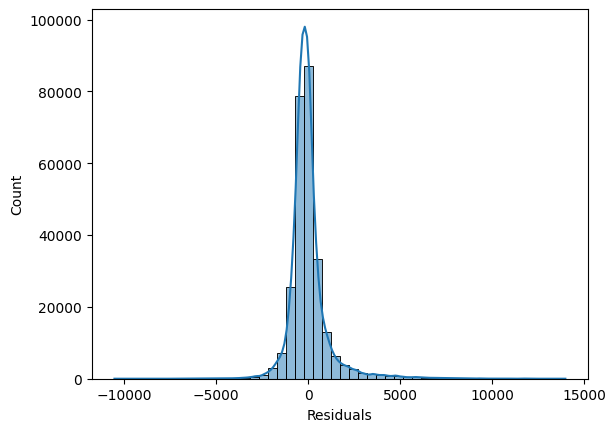

In [38]:
plot_functions.plot_residuals(lr_model.evaluate(testing_data))

2023-06-06 05:48:19,796 INFO optimize.LBFGS: Step Size: 1.056
2023-06-06 05:48:19,797 INFO optimize.LBFGS: Val and Grad Norm: 0.432545 (rel: 0.135) 1.00555
2023-06-06 05:48:19,856 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 05:48:19,856 INFO optimize.LBFGS: Val and Grad Norm: 0.209742 (rel: 0.515) 0.116138
2023-06-06 05:48:19,952 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 05:48:19,952 INFO optimize.LBFGS: Val and Grad Norm: 0.205036 (rel: 0.0224) 0.0445094
2023-06-06 05:48:20,018 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 05:48:20,019 INFO optimize.LBFGS: Val and Grad Norm: 0.203864 (rel: 0.00571) 0.0182757
2023-06-06 05:48:20,102 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 05:48:20,102 INFO optimize.LBFGS: Val and Grad Norm: 0.203543 (rel: 0.00157) 0.0138056
2023-06-06 05:48:20,194 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 05:48:20,194 INFO optimize.LBFGS: Val and Grad Norm: 0.203280 (rel: 0.00130) 0.00279612
2023-06-06 05:48:20,380 INFO optimize.StrongWol

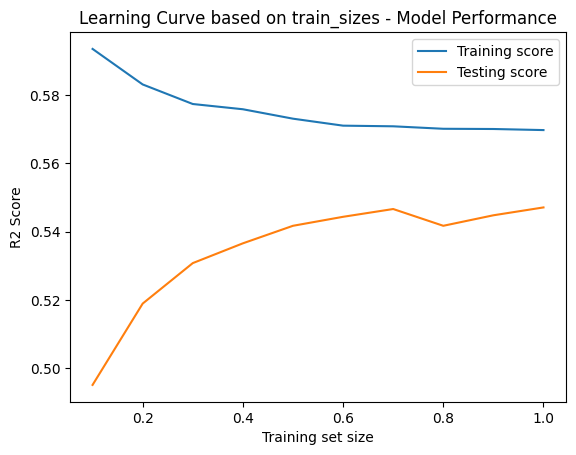

In [39]:
plot_functions.plot_learning_curve(training_data, testing_data)

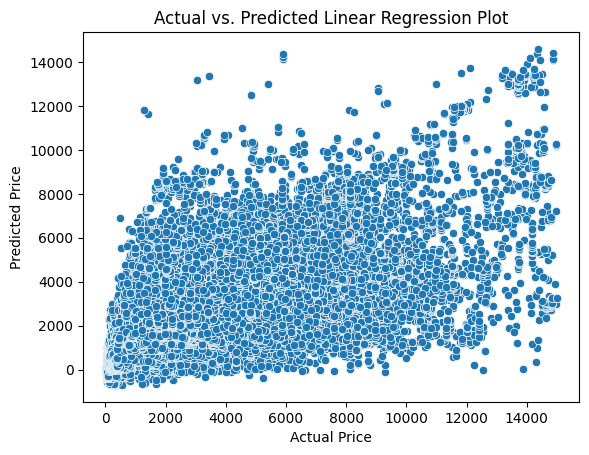

In [40]:
plot_functions.plot_actual_vs_predicted(lr_predictions)

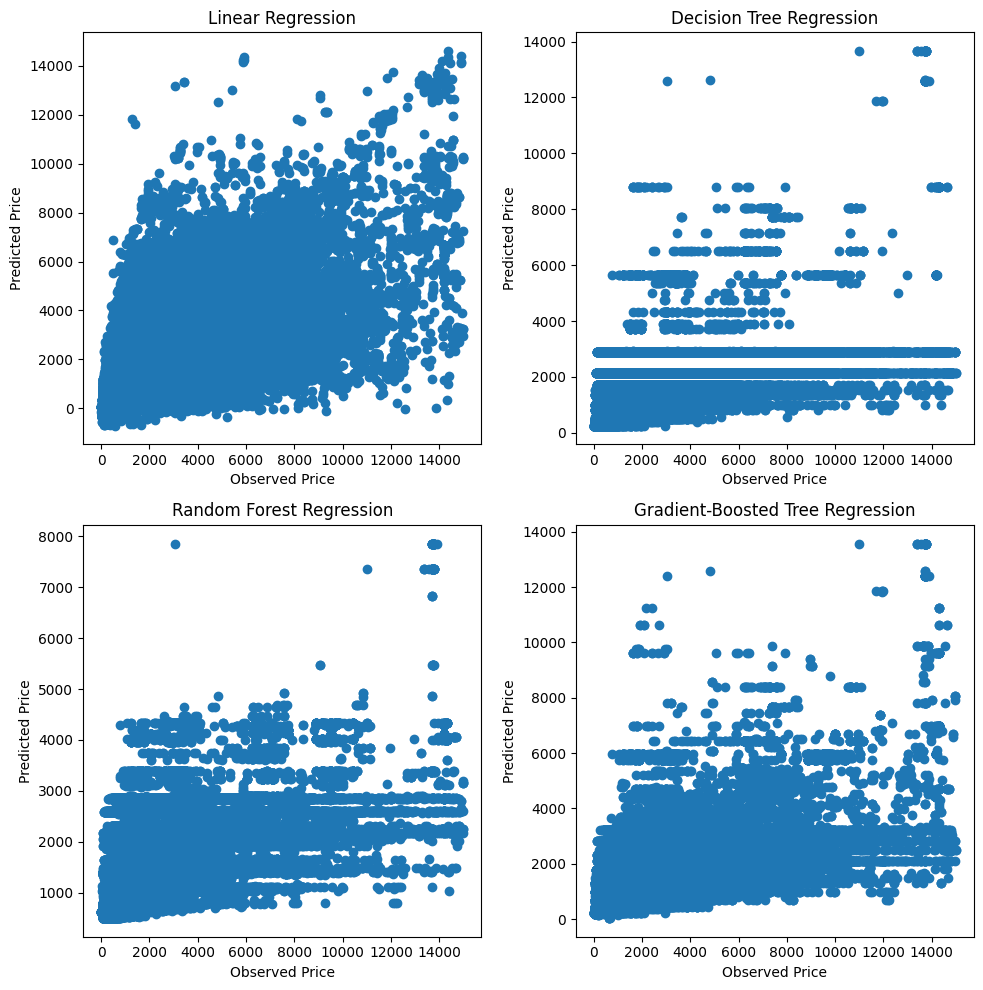

In [41]:
plot_functions.plot_scatter_plots(lr_predictions, dt_predictions, rf_predictions, gbt_predictions)

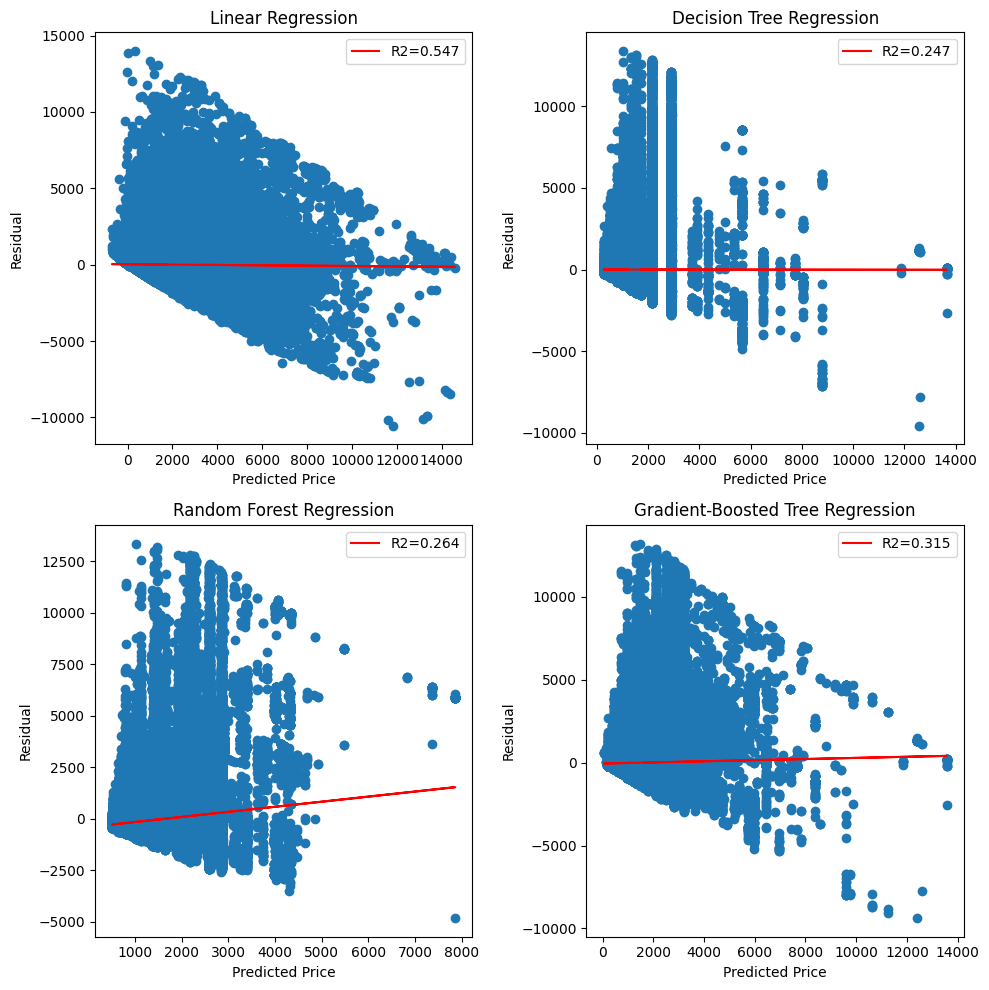

In [42]:
plot_functions.plot_residual_models(lr_predictions, dt_predictions, rf_predictions, gbt_predictions, 
                                    lr_r2_score, dt_r2_score, rf_r2_score, gbt_r2_score)

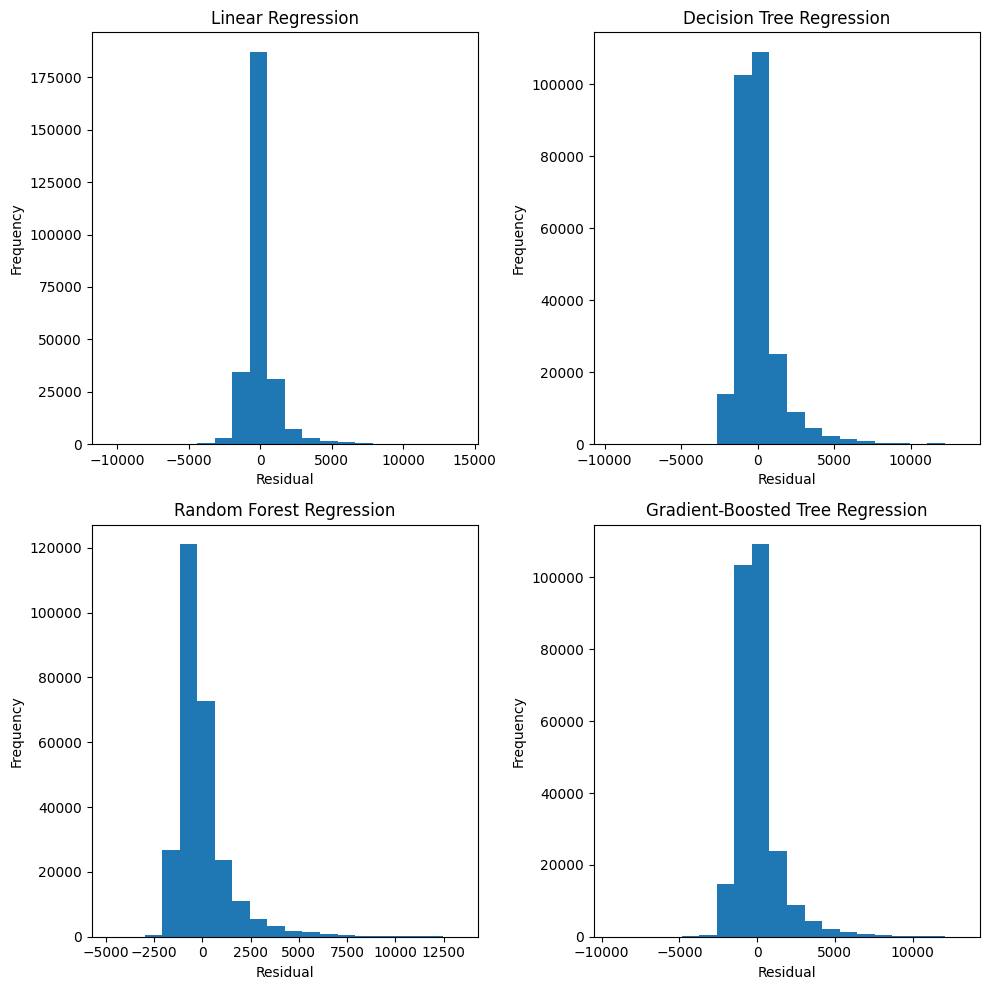

In [44]:
plot_functions.plot_residual_histograms(lr_predictions, dt_predictions, rf_predictions, gbt_predictions)

In [45]:
# Redo with Price restricted to less than 5k
training_data, testing_data = data_functions.prepare_data(df5k)
training_data.cache()
testing_data.cache()

DataFrame[airline_name: string, duration: float, stops: float, price: float, airline_name_index: double, airline_name_encoded: vector, stops_int: int, features: vector]

In [46]:
# Retrieve model/predictions/r2 from functions
lr_model, lr_predictions, lr_r2_score = data_functions.fit_and_evaluate_model(LinearRegression, training_data, testing_data)
dt_model, dt_predictions, dt_r2_score = data_functions.fit_and_evaluate_model(DecisionTreeRegressor, training_data, testing_data)
rf_model, rf_predictions, rf_r2_score = data_functions.fit_and_evaluate_model(RandomForestRegressor, training_data, testing_data)
gbt_model, gbt_predictions, gbt_r2_score = data_functions.fit_and_evaluate_model(GBTRegressor, training_data, testing_data)

data_functions.display_performance(lr_r2_score=lr_r2_score,
                    dt_r2_score=dt_r2_score,
                    rf_r2_score=rf_r2_score,
                    gbt_r2_score=gbt_r2_score)

2023-06-06 05:52:41,743 INFO optimize.LBFGS: Step Size: 1.033                   
2023-06-06 05:52:41,744 INFO optimize.LBFGS: Val and Grad Norm: 0.446669 (rel: 0.107) 1.02092
2023-06-06 05:52:41,846 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 05:52:41,846 INFO optimize.LBFGS: Val and Grad Norm: 0.214282 (rel: 0.520) 0.118017
2023-06-06 05:52:41,927 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 05:52:41,927 INFO optimize.LBFGS: Val and Grad Norm: 0.209339 (rel: 0.0231) 0.0491173
2023-06-06 05:52:42,042 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 05:52:42,043 INFO optimize.LBFGS: Val and Grad Norm: 0.207925 (rel: 0.00676) 0.0173670
2023-06-06 05:52:42,125 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 05:52:42,125 INFO optimize.LBFGS: Val and Grad Norm: 0.207641 (rel: 0.00137) 0.0128203
2023-06-06 05:52:42,191 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 05:52:42,191 INFO optimize.LBFGS: Val and Grad Norm: 0.207412 (rel: 0.00110) 0.00267803
2023-06-06 05:52:42,386 INFO

,Model,R2 Score
0,Linear Regression,0.565377
1,Decision Tree Regression,0.291759
2,Random Forest Regression,0.299486
3,Gradient-Boosted Tree Regression,0.343400


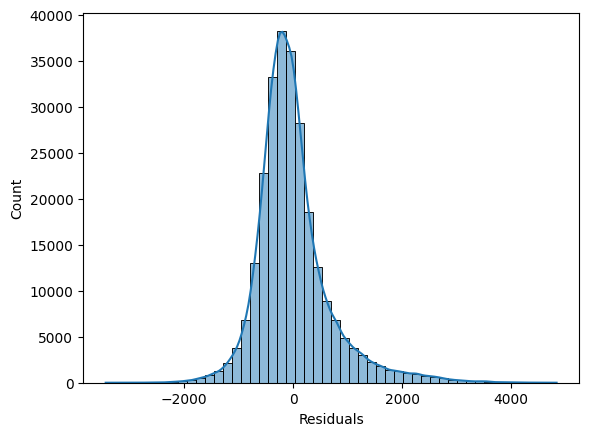

In [47]:
plot_functions.plot_residuals(lr_model.evaluate(testing_data))

2023-06-06 06:43:18,305 INFO optimize.LBFGS: Step Size: 1.018
2023-06-06 06:43:18,305 INFO optimize.LBFGS: Val and Grad Norm: 0.425477 (rel: 0.149) 1.00444
2023-06-06 06:43:18,417 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 06:43:18,417 INFO optimize.LBFGS: Val and Grad Norm: 0.201962 (rel: 0.525) 0.120556
2023-06-06 06:43:18,522 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 06:43:18,522 INFO optimize.LBFGS: Val and Grad Norm: 0.196825 (rel: 0.0254) 0.0485779
2023-06-06 06:43:18,645 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 06:43:18,645 INFO optimize.LBFGS: Val and Grad Norm: 0.195457 (rel: 0.00695) 0.0173251
2023-06-06 06:43:18,722 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 06:43:18,722 INFO optimize.LBFGS: Val and Grad Norm: 0.195173 (rel: 0.00145) 0.0130716
2023-06-06 06:43:18,826 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 06:43:18,826 INFO optimize.LBFGS: Val and Grad Norm: 0.194922 (rel: 0.00129) 0.00312897
2023-06-06 06:43:19,012 INFO optimize.StrongWol

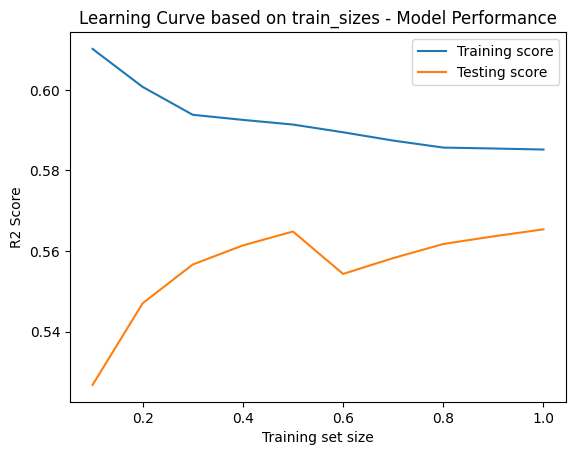

In [48]:
plot_functions.plot_learning_curve(training_data, testing_data)

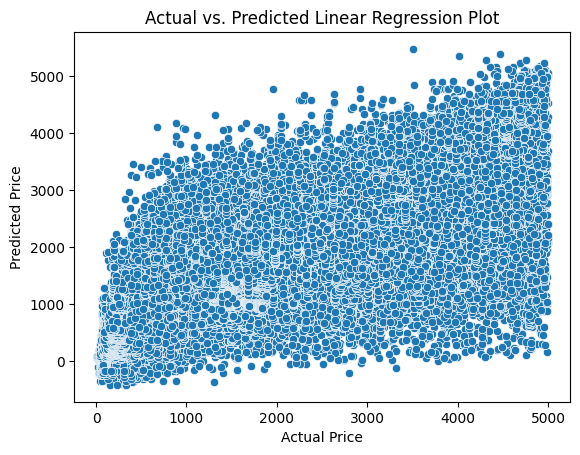

In [49]:
plot_functions.plot_actual_vs_predicted(lr_predictions)

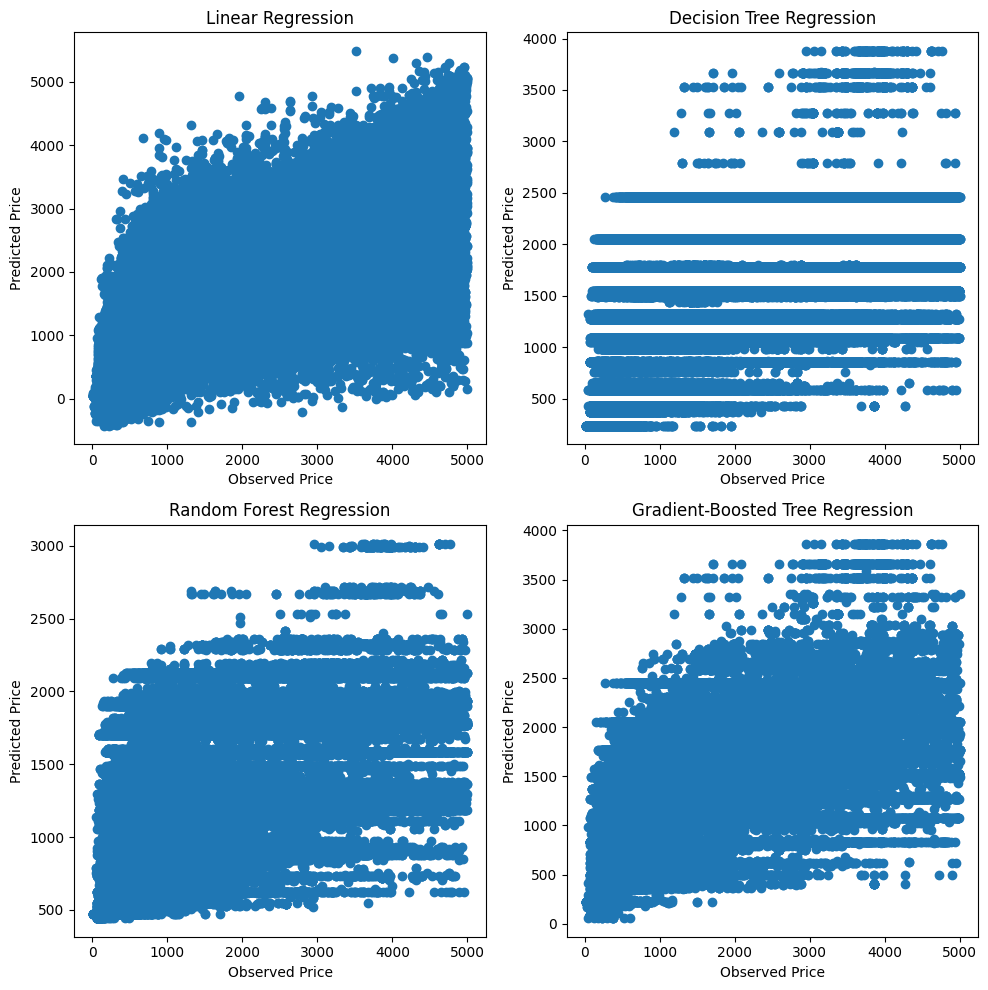

In [50]:
plot_functions.plot_scatter_plots(lr_predictions, dt_predictions, rf_predictions, gbt_predictions)

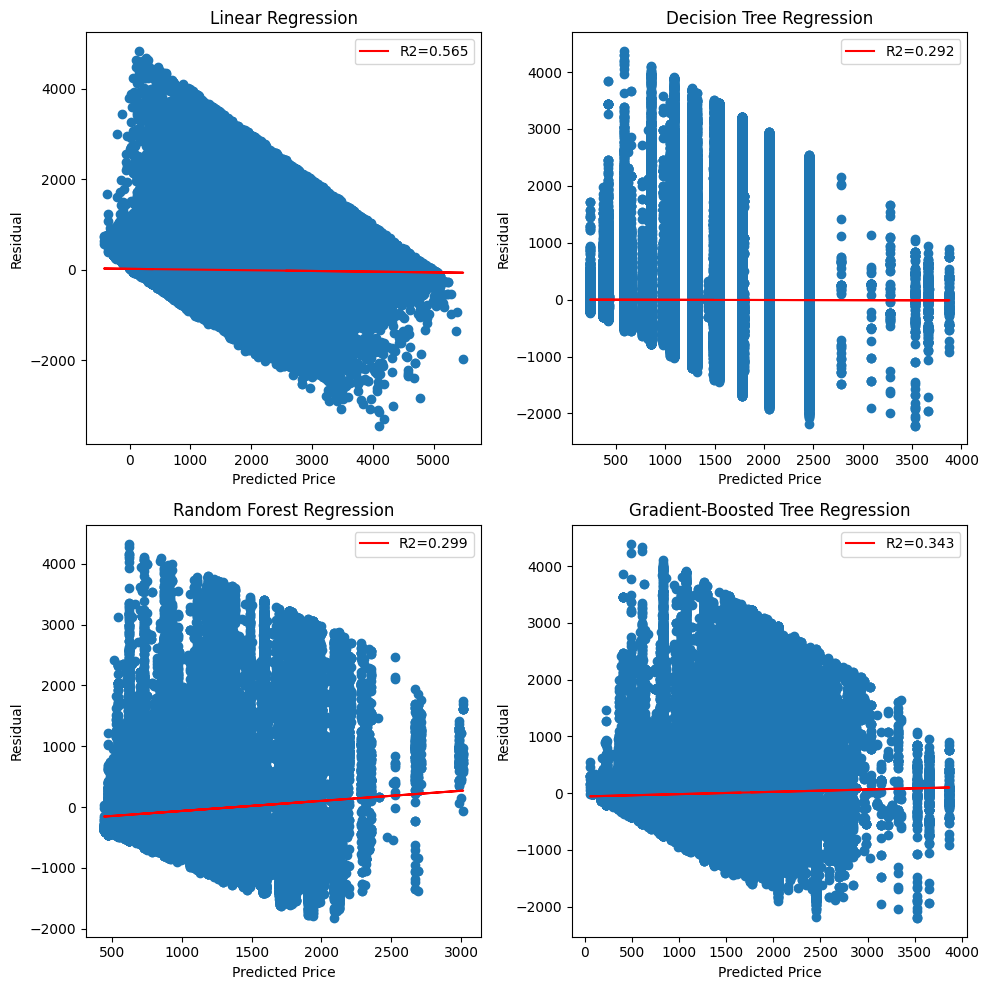

In [51]:
plot_functions.plot_residual_models(lr_predictions, dt_predictions, rf_predictions, gbt_predictions, 
                                    lr_r2_score, dt_r2_score, rf_r2_score, gbt_r2_score)

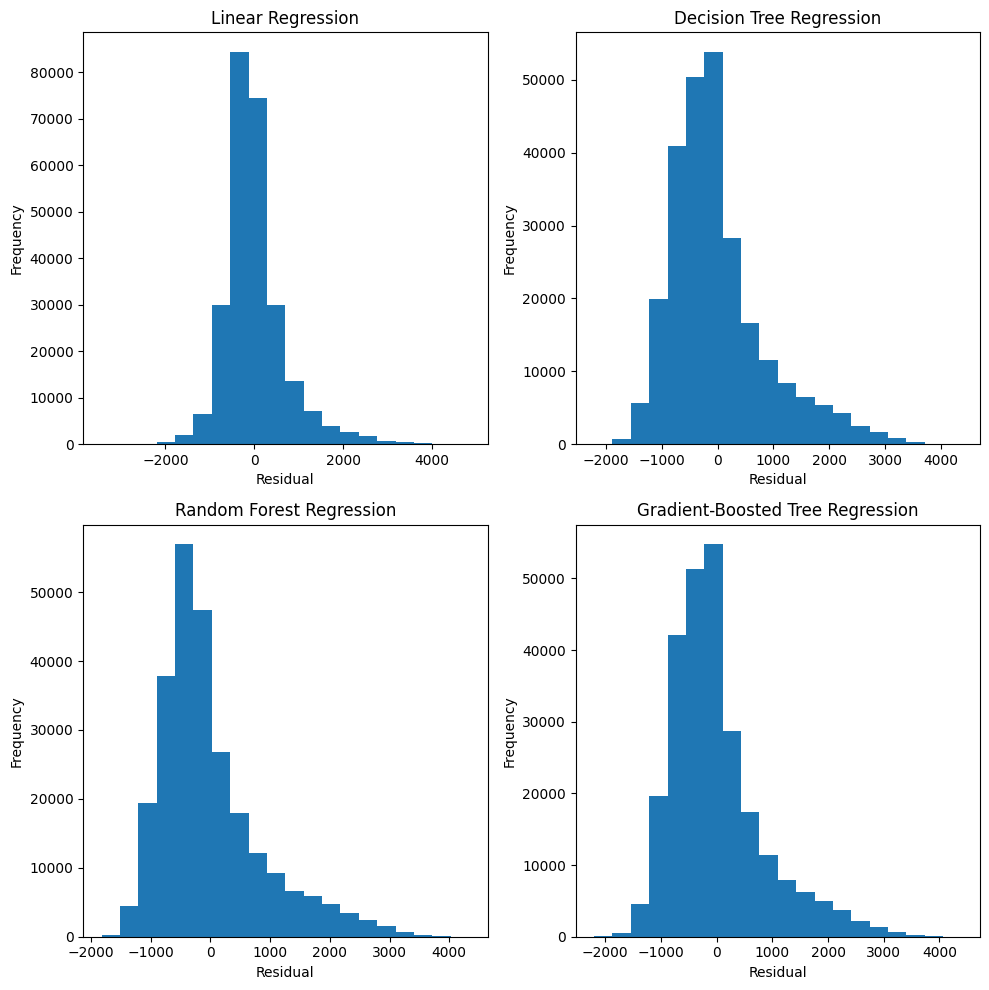

In [53]:
plot_functions.plot_residual_histograms(lr_predictions, dt_predictions, rf_predictions, gbt_predictions)

In [54]:
# Redo with Price restricted to less than 10k
training_data, testing_data = data_functions.prepare_data(df10k)
training_data.cache()
testing_data.cache()

DataFrame[airline_name: string, duration: float, stops: float, price: float, airline_name_index: double, airline_name_encoded: vector, stops_int: int, features: vector]

In [55]:
# Retrieve model/predictions/r2 from functions
lr_model, lr_predictions, lr_r2_score = data_functions.fit_and_evaluate_model(LinearRegression, training_data, testing_data)
dt_model, dt_predictions, dt_r2_score = data_functions.fit_and_evaluate_model(DecisionTreeRegressor, training_data, testing_data)
rf_model, rf_predictions, rf_r2_score = data_functions.fit_and_evaluate_model(RandomForestRegressor, training_data, testing_data)
gbt_model, gbt_predictions, gbt_r2_score = data_functions.fit_and_evaluate_model(GBTRegressor, training_data, testing_data)

data_functions.display_performance(lr_r2_score=lr_r2_score,
                    dt_r2_score=dt_r2_score,
                    rf_r2_score=rf_r2_score,
                    gbt_r2_score=gbt_r2_score)

2023-06-06 06:48:38,555 WARN netlib.InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
2023-06-06 06:48:38,828 INFO optimize.LBFGS: Step Size: 1.311
2023-06-06 06:48:38,853 INFO optimize.LBFGS: Val and Grad Norm: 0.265294 (rel: 0.469) 0.360728
2023-06-06 06:48:38,857 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 06:48:38,862 INFO optimize.LBFGS: Val and Grad Norm: 0.222101 (rel: 0.163) 0.119202
2023-06-06 06:48:38,868 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 06:48:38,873 INFO optimize.LBFGS: Val and Grad Norm: 0.218554 (rel: 0.0160) 0.0146357
2023-06-06 06:48:38,878 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 06:48:38,883 INFO optimize.LBFGS: Val and Grad Norm: 0.218476 (rel: 0.000358) 0.00614298
2023-06-06 06:48:38,889 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 06:48:38,892 INFO optimize.LBFGS: Val and Grad Norm: 0.218447 (rel: 0.000129) 0.00476361
2023-06-06 06:48:38,896 INFO optimize.LBFGS: Step Size: 1.000
2023

,Model,R2 Score
0,Linear Regression,0.486074
1,Decision Tree Regression,0.162638
2,Random Forest Regression,0.168974
3,Gradient-Boosted Tree Regression,0.242234


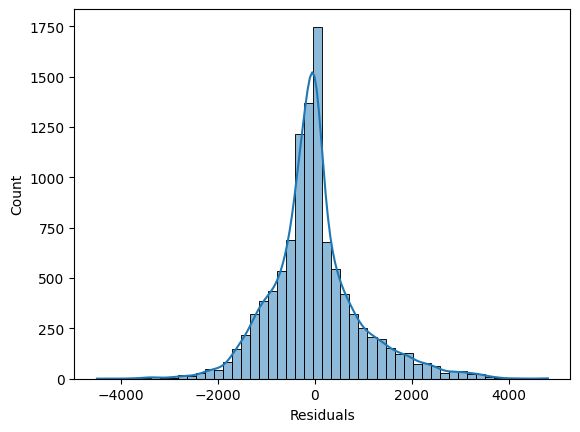

In [56]:
plot_functions.plot_residuals(lr_model.evaluate(testing_data))

2023-06-06 06:49:30,499 INFO optimize.LBFGS: Step Size: 1.184                   
2023-06-06 06:49:30,503 INFO optimize.LBFGS: Val and Grad Norm: 0.183643 (rel: 0.633) 0.303825
2023-06-06 06:49:30,507 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 06:49:30,511 INFO optimize.LBFGS: Val and Grad Norm: 0.159783 (rel: 0.130) 0.143747
2023-06-06 06:49:30,516 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 06:49:30,523 INFO optimize.LBFGS: Val and Grad Norm: 0.154684 (rel: 0.0319) 0.00850829
2023-06-06 06:49:30,531 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 06:49:30,534 INFO optimize.LBFGS: Val and Grad Norm: 0.154651 (rel: 0.000215) 0.00707034
2023-06-06 06:49:30,539 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 06:49:30,542 INFO optimize.LBFGS: Val and Grad Norm: 0.154552 (rel: 0.000636) 0.00343191
2023-06-06 06:49:30,547 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 06:49:30,553 INFO optimize.LBFGS: Val and Grad Norm: 0.154551 (rel: 1.12e-05) 0.00370421
2023-06-06 06:49:30,5

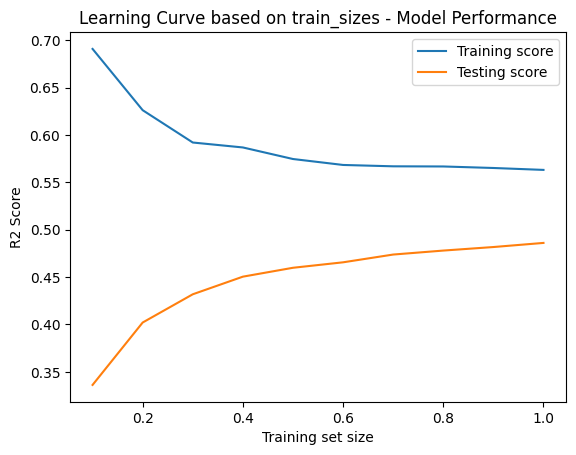

In [57]:
plot_functions.plot_learning_curve(training_data, testing_data)

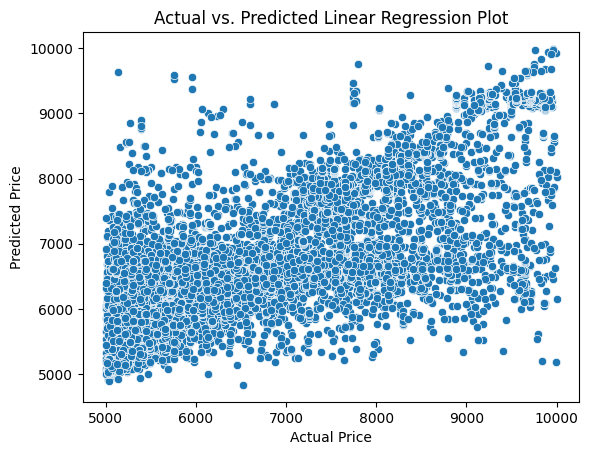

In [58]:
plot_functions.plot_actual_vs_predicted(lr_predictions)

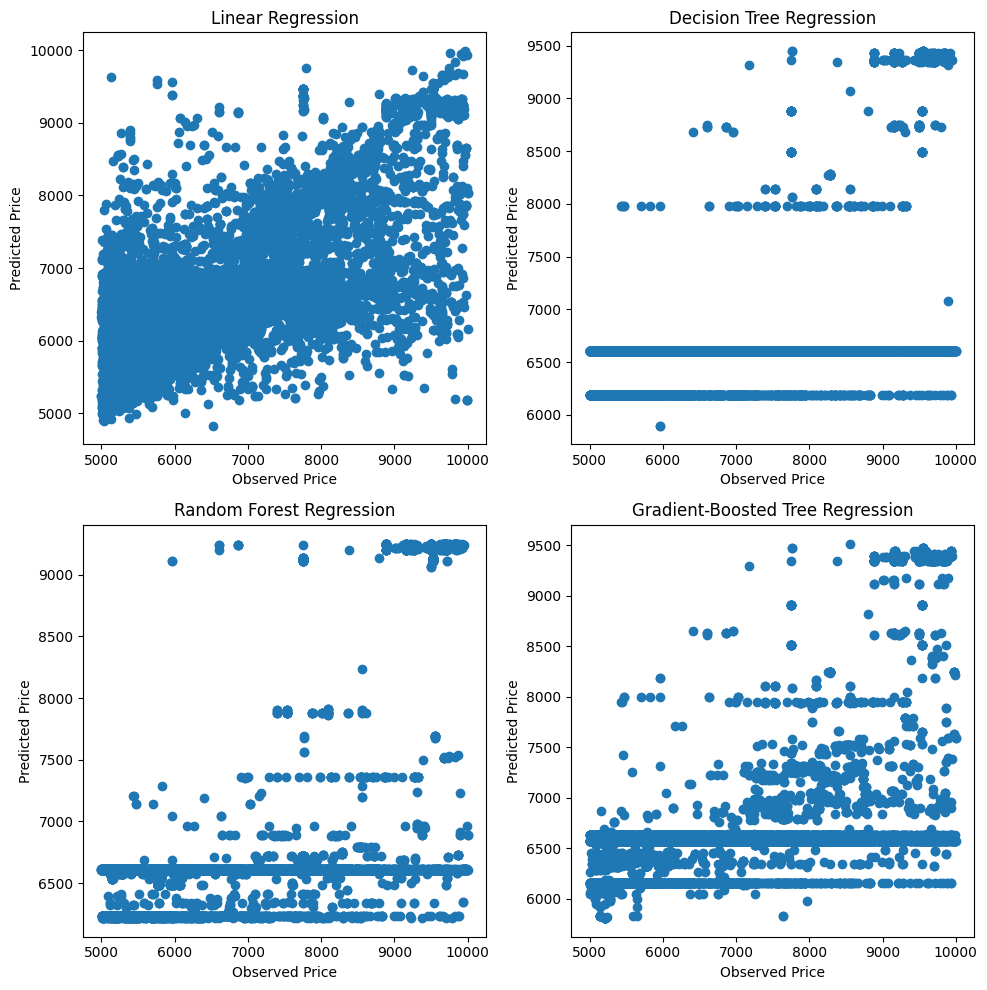

In [59]:
plot_functions.plot_scatter_plots(lr_predictions, dt_predictions, rf_predictions, gbt_predictions)

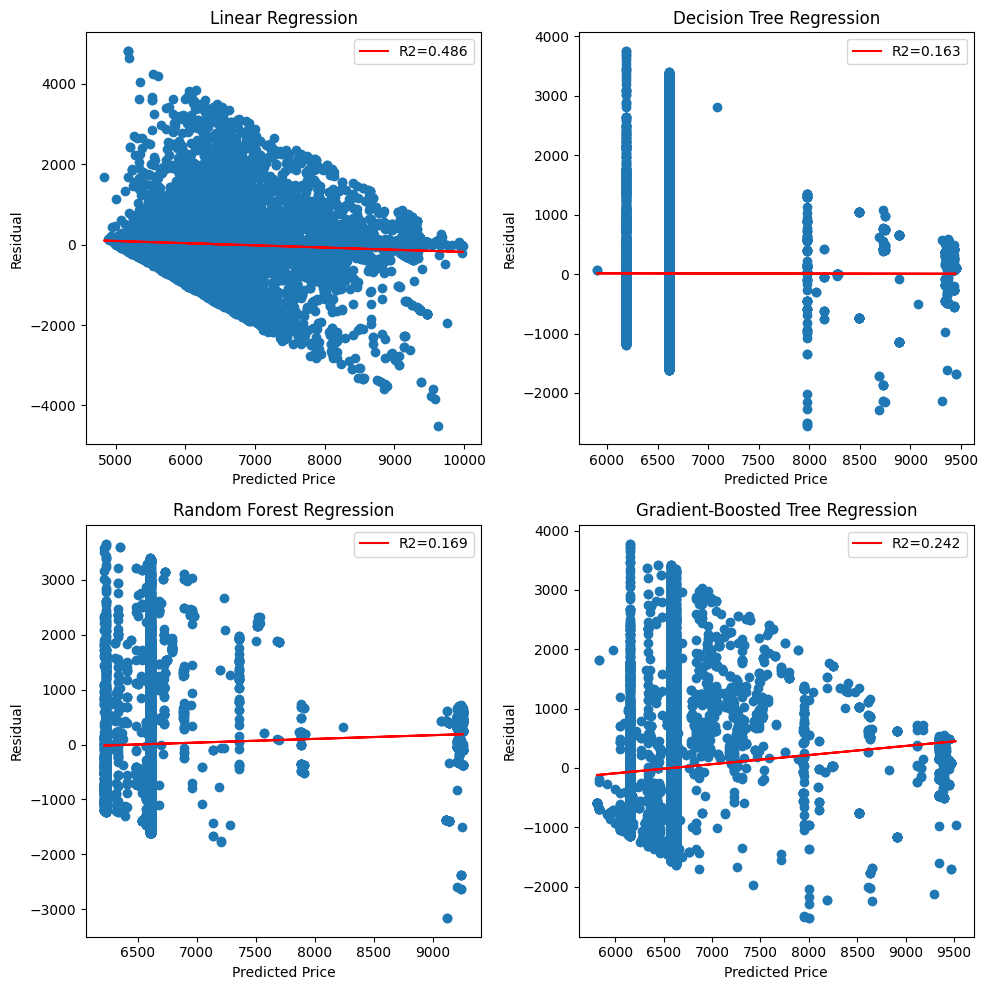

In [60]:
plot_functions.plot_residual_models(lr_predictions, dt_predictions, rf_predictions, gbt_predictions, 
                                    lr_r2_score, dt_r2_score, rf_r2_score, gbt_r2_score)

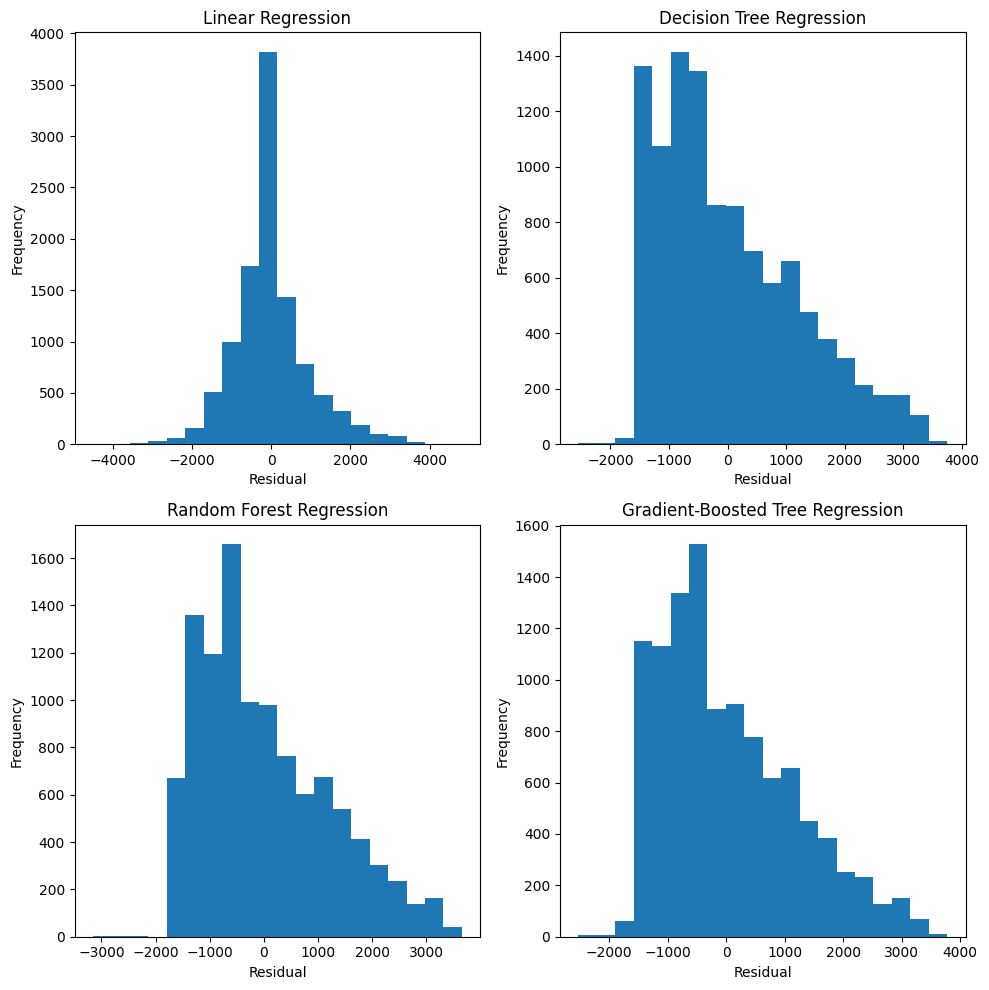

In [61]:
plot_functions.plot_residual_histograms(lr_predictions, dt_predictions, rf_predictions, gbt_predictions)

In [62]:
# Redo with Price restricted to less than 15k
training_data, testing_data = data_functions.prepare_data(df15k)
training_data.cache()
testing_data.cache()

DataFrame[airline_name: string, duration: float, stops: float, price: float, airline_name_index: double, airline_name_encoded: vector, stops_int: int, features: vector]

In [63]:
# Retrieve model/predictions/r2 from functions
lr_model, lr_predictions, lr_r2_score = data_functions.fit_and_evaluate_model(LinearRegression, training_data, testing_data)
dt_model, dt_predictions, dt_r2_score = data_functions.fit_and_evaluate_model(DecisionTreeRegressor, training_data, testing_data)
rf_model, rf_predictions, rf_r2_score = data_functions.fit_and_evaluate_model(RandomForestRegressor, training_data, testing_data)
gbt_model, gbt_predictions, gbt_r2_score = data_functions.fit_and_evaluate_model(GBTRegressor, training_data, testing_data)

data_functions.display_performance(lr_r2_score=lr_r2_score,
                    dt_r2_score=dt_r2_score,
                    rf_r2_score=rf_r2_score,
                    gbt_r2_score=gbt_r2_score)

2023-06-06 06:49:55,440 INFO optimize.LBFGS: Step Size: 1.110                   
2023-06-06 06:49:55,441 INFO optimize.LBFGS: Val and Grad Norm: 0.149757 (rel: 0.700) 0.337101
2023-06-06 06:49:55,441 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 06:49:55,442 INFO optimize.LBFGS: Val and Grad Norm: 0.123487 (rel: 0.175) 0.143793
2023-06-06 06:49:55,442 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 06:49:55,442 INFO optimize.LBFGS: Val and Grad Norm: 0.118181 (rel: 0.0430) 0.0170968
2023-06-06 06:49:55,442 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 06:49:55,443 INFO optimize.LBFGS: Val and Grad Norm: 0.118037 (rel: 0.00122) 0.0147317
2023-06-06 06:49:55,444 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 06:49:55,444 INFO optimize.LBFGS: Val and Grad Norm: 0.117563 (rel: 0.00402) 0.00686988
2023-06-06 06:49:55,445 INFO optimize.StrongWolfeLineSearch: Line search t: 0.23604444231738086 fval: 0.11755137528874471 rhs: 0.11756302129065413 cdd: 5.6529831170108475E-15
2023-06-06 0

,Model,R2 Score
0,Linear Regression,0.651823
1,Decision Tree Regression,0.332864
2,Random Forest Regression,0.409719
3,Gradient-Boosted Tree Regression,0.592450


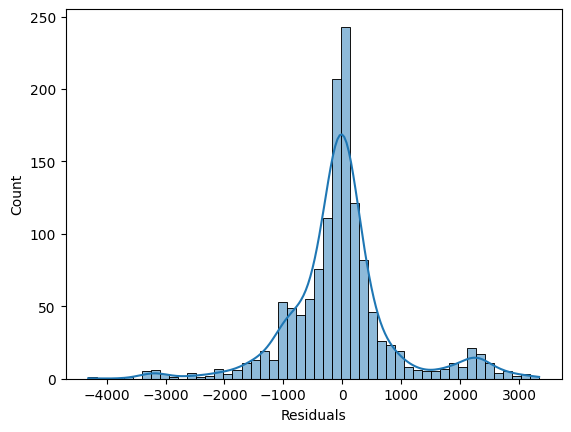

In [64]:
plot_functions.plot_residuals(lr_model.evaluate(testing_data))

2023-06-06 06:50:06,459 INFO optimize.LBFGS: Step Size: 1.066
2023-06-06 06:50:06,459 INFO optimize.LBFGS: Val and Grad Norm: 0.110468 (rel: 0.779) 0.310712
2023-06-06 06:50:06,459 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 06:50:06,459 INFO optimize.LBFGS: Val and Grad Norm: 0.0909509 (rel: 0.177) 0.156236
2023-06-06 06:50:06,460 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 06:50:06,460 INFO optimize.LBFGS: Val and Grad Norm: 0.0847712 (rel: 0.0679) 0.0270150
2023-06-06 06:50:06,460 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 06:50:06,460 INFO optimize.LBFGS: Val and Grad Norm: 0.0844007 (rel: 0.00437) 0.0239099
2023-06-06 06:50:06,460 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 06:50:06,460 INFO optimize.LBFGS: Val and Grad Norm: 0.0828619 (rel: 0.0182) 0.0114862
2023-06-06 06:50:06,461 INFO optimize.StrongWolfeLineSearch: Line search t: 0.2956259915159728 fval: 0.08284154744972838 rhs: 0.08286194429757945 cdd: -5.436978280516213E-15
2023-06-06 06:50:06,461 INFO o

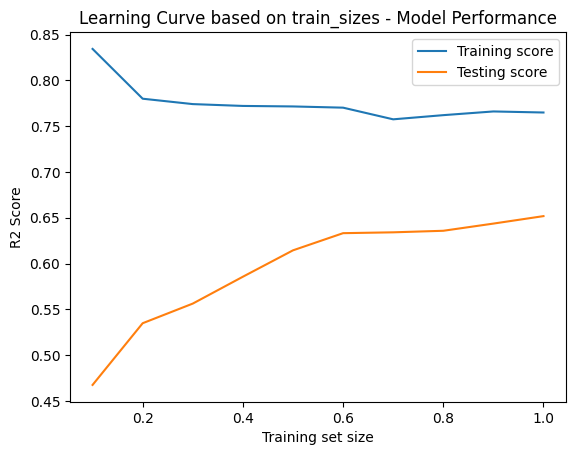

In [65]:
plot_functions.plot_learning_curve(training_data, testing_data)

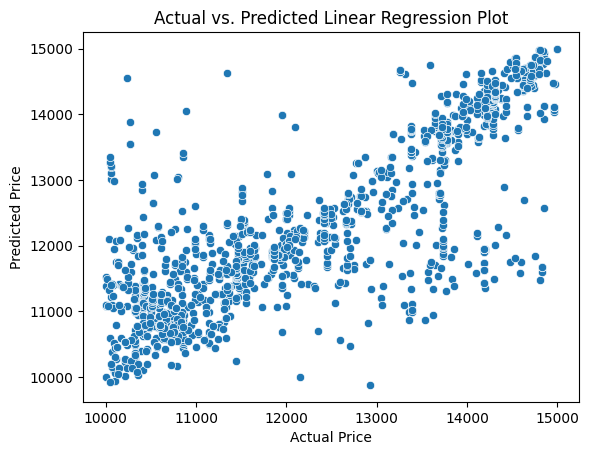

In [66]:
plot_functions.plot_actual_vs_predicted(lr_predictions)

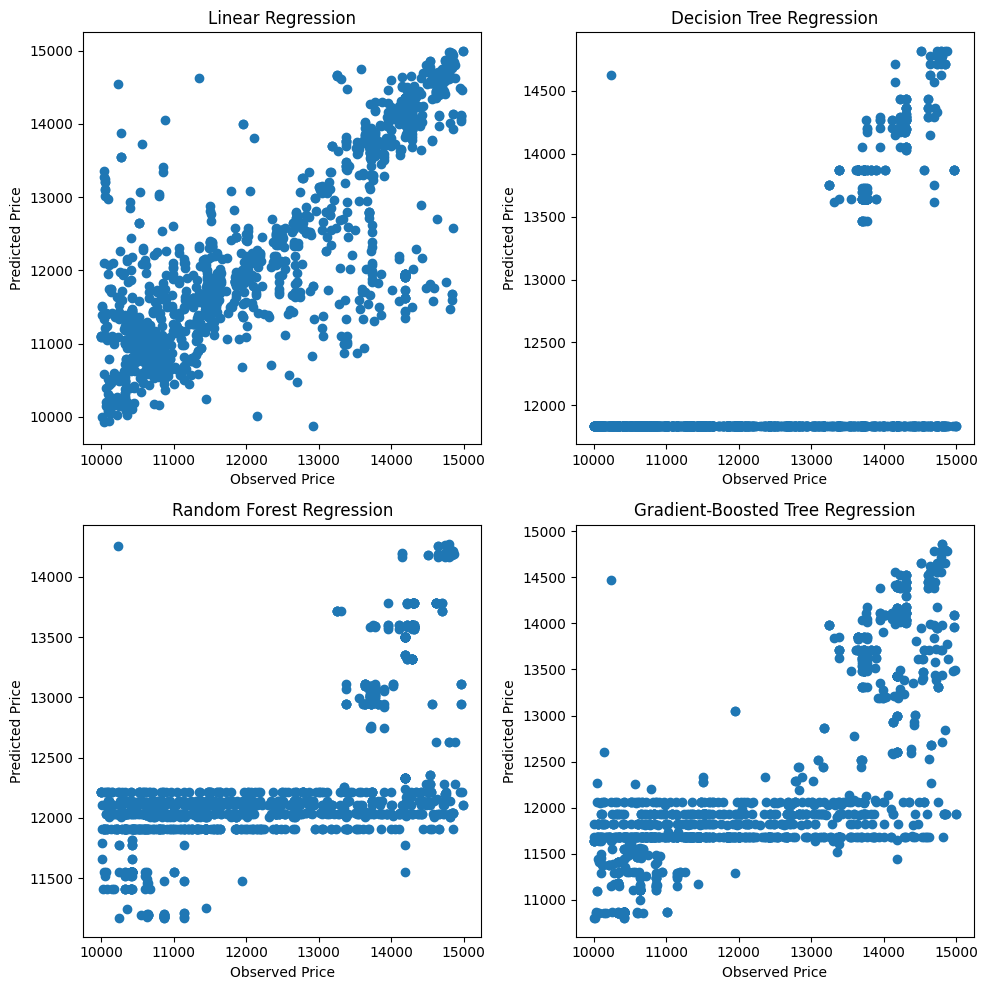

In [67]:
plot_functions.plot_scatter_plots(lr_predictions, dt_predictions, rf_predictions, gbt_predictions)

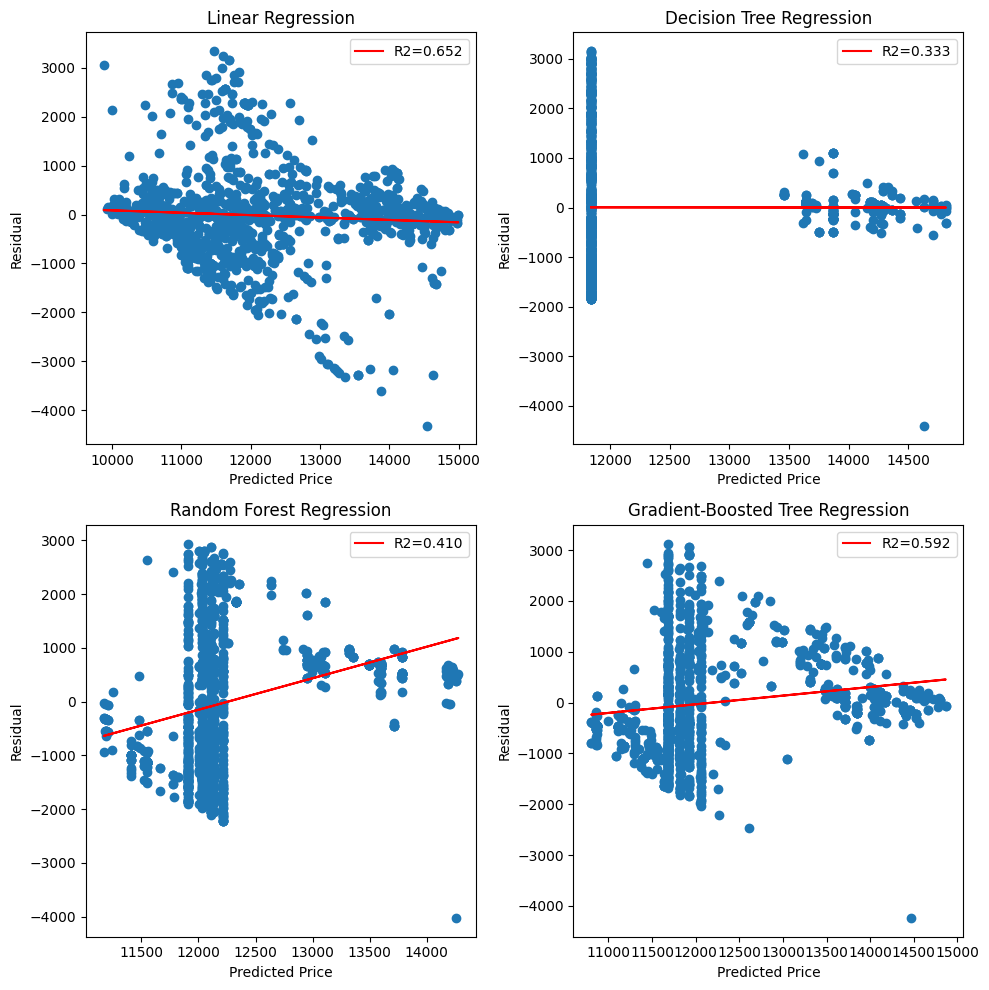

In [68]:
plot_functions.plot_residual_models(lr_predictions, dt_predictions, rf_predictions, gbt_predictions, 
                                    lr_r2_score, dt_r2_score, rf_r2_score, gbt_r2_score)

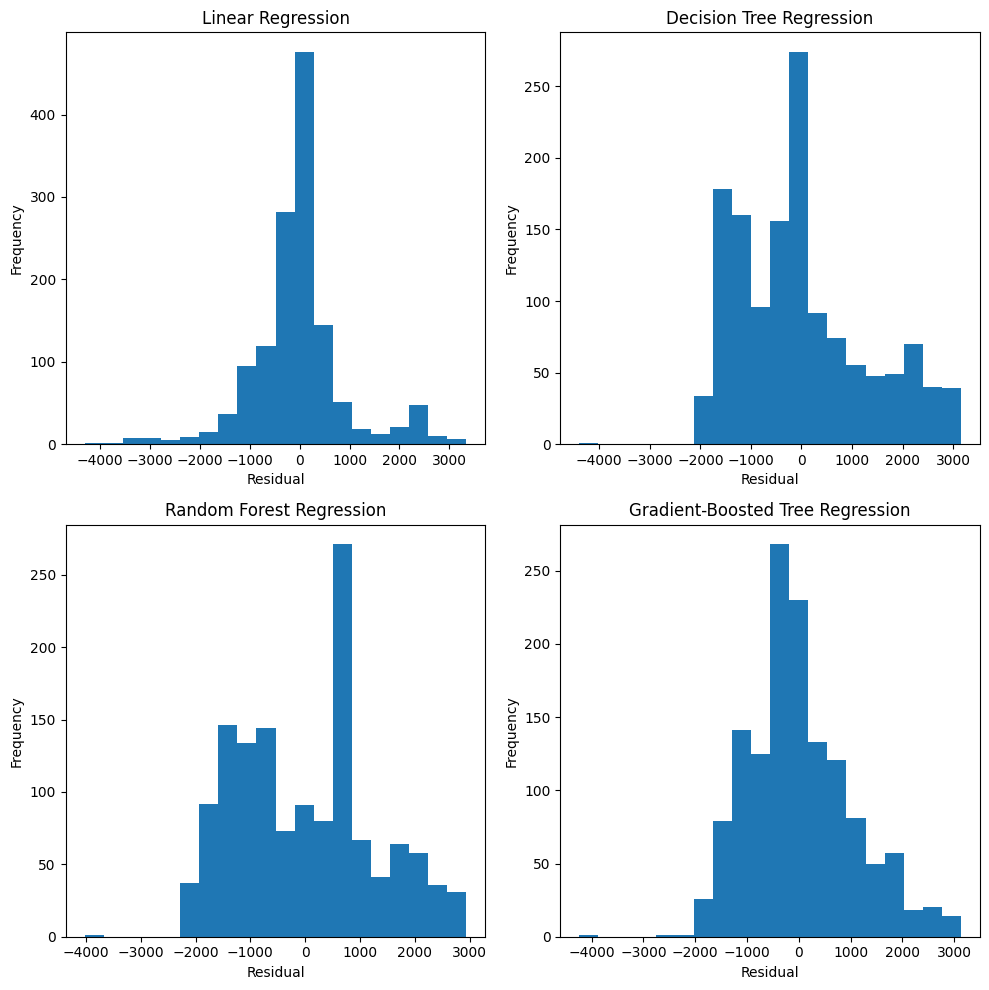

In [69]:
plot_functions.plot_residual_histograms(lr_predictions, dt_predictions, rf_predictions, gbt_predictions)

2023-06-06 06:50:43,905 INFO optimize.LBFGS: Step Size: 6.817                   
2023-06-06 06:50:43,905 INFO optimize.LBFGS: Val and Grad Norm: 2.68289 (rel: 0.0336) 0.0602429
2023-06-06 06:50:44,077 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 06:50:44,077 INFO optimize.LBFGS: Val and Grad Norm: 2.65541 (rel: 0.0102) 0.0361375
2023-06-06 06:50:44,214 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 06:50:44,214 INFO optimize.LBFGS: Val and Grad Norm: 2.64422 (rel: 0.00422) 0.0318033
2023-06-06 06:50:44,379 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 06:50:44,379 INFO optimize.LBFGS: Val and Grad Norm: 2.64057 (rel: 0.00138) 0.0116181
2023-06-06 06:50:44,493 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 06:50:44,493 INFO optimize.LBFGS: Val and Grad Norm: 2.63980 (rel: 0.000291) 0.00863786
2023-06-06 06:50:44,724 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 06:50:44,724 INFO optimize.LBFGS: Val and Grad Norm: 2.63868 (rel: 0.000424) 0.00467496
2023-06-06 06:50:44,979 I

Test accuracy: 0.19


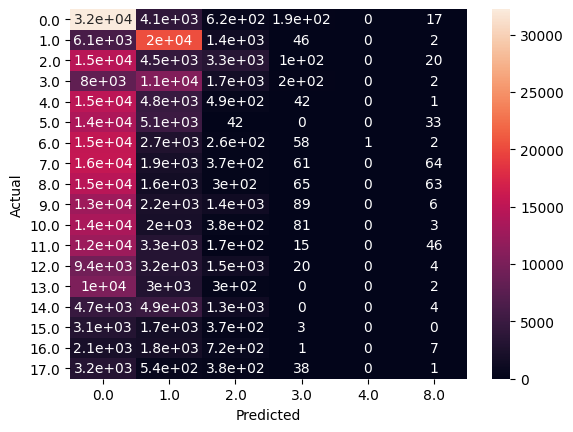

In [72]:
data_functions.multiClass_generator(df5k)

2023-06-06 06:51:08,740 INFO optimize.LBFGS: Step Size: 4.435                   
2023-06-06 06:51:08,740 INFO optimize.LBFGS: Val and Grad Norm: 2.15809 (rel: 0.0591) 0.0929539
2023-06-06 06:51:08,761 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 06:51:08,761 INFO optimize.LBFGS: Val and Grad Norm: 2.11472 (rel: 0.0201) 0.0562569
2023-06-06 06:51:08,783 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 06:51:08,784 INFO optimize.LBFGS: Val and Grad Norm: 2.07977 (rel: 0.0165) 0.0376979
2023-06-06 06:51:08,808 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 06:51:08,808 INFO optimize.LBFGS: Val and Grad Norm: 2.07472 (rel: 0.00243) 0.0734017
2023-06-06 06:51:08,826 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 06:51:08,826 INFO optimize.LBFGS: Val and Grad Norm: 2.06363 (rel: 0.00534) 0.0206970
2023-06-06 06:51:08,872 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 06:51:08,872 INFO optimize.LBFGS: Val and Grad Norm: 2.06177 (rel: 0.000902) 0.0167915
2023-06-06 06:51:08,895 INFO 

Test accuracy: 0.36


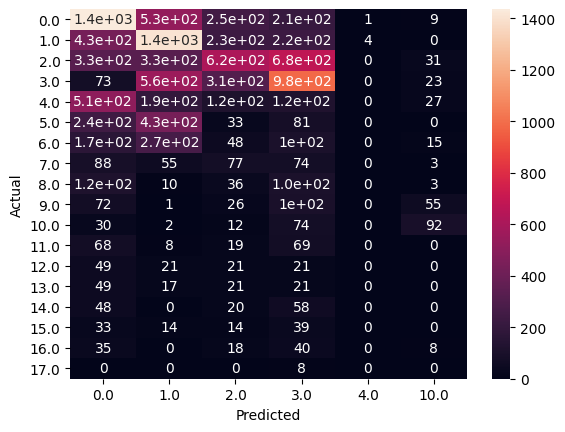

In [73]:
data_functions.multiClass_generator(df10k)

2023-06-06 06:53:04,309 INFO optimize.LBFGS: Step Size: 2.906                   
2023-06-06 06:53:04,309 INFO optimize.LBFGS: Val and Grad Norm: 1.49410 (rel: 0.132) 0.153678
2023-06-06 06:53:04,334 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 06:53:04,334 INFO optimize.LBFGS: Val and Grad Norm: 1.40475 (rel: 0.0598) 0.0727772
2023-06-06 06:53:04,356 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 06:53:04,356 INFO optimize.LBFGS: Val and Grad Norm: 1.36768 (rel: 0.0264) 0.0354532
2023-06-06 06:53:04,383 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 06:53:04,383 INFO optimize.LBFGS: Val and Grad Norm: 1.35477 (rel: 0.00943) 0.0495135
2023-06-06 06:53:04,412 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 06:53:04,412 INFO optimize.LBFGS: Val and Grad Norm: 1.34917 (rel: 0.00414) 0.0305481
2023-06-06 06:53:04,436 INFO optimize.LBFGS: Step Size: 1.000
2023-06-06 06:53:04,436 INFO optimize.LBFGS: Val and Grad Norm: 1.34678 (rel: 0.00177) 0.0169142
2023-06-06 06:53:04,465 INFO opt

Test accuracy: 0.51


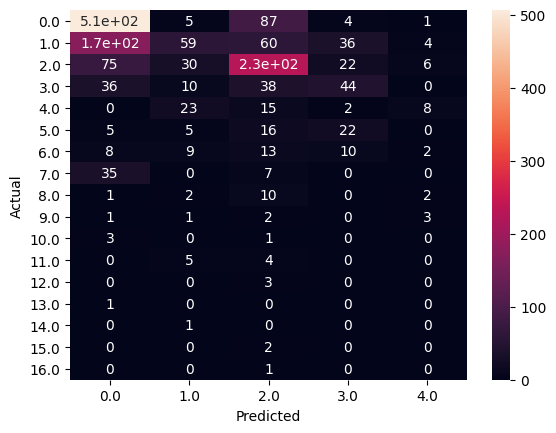

In [76]:
data_functions.multiClass_generator(df15k)

In [ ]:
# Conclude Spark Session
spark.stop()